# IMPRORT

In [1]:
from typing import Any
from py3.k_means import PixelValueGenerator, CustomKMeans
import numpy as np
from py3.CNN_model import Cplx_CustomCNN_1D
from py3.Attention_Layer import CustomAttentionLayer
from py3.classification import CustomClassifierModel
import tensorflow as tf

import re
import numpy as np
import pandas as pd

In [2]:
class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    END = '\033[0m'

In [3]:
df = pd.read_csv('post_processed_data.csv')
print(df.head())


def extract_multiple_arrays(string_repr):
    # Remove letters, parentheses, spaces, and unwanted sequences
    string_repr = re.sub('[a-df-zA-DF-Z\(\)\s]', '', string_repr)
    string_repr = re.sub(r',=32', '', string_repr)

    # Find all matches of arrays within the string
    arrays = re.findall(r'\[.*?\]', string_repr)

    # Convert each found array string into a NumPy array
    #np_arrays = [np.array(re.findall(r'[+-]?\d+(?:\.\d+)?', array), dtype=float) for array in arrays]
    np_arrays = [np.array(re.findall(r'[+-]?\d+(?:\.\d+)?(?:e[+-]?\d+)?', array), dtype=float) for array in arrays]
    return np_arrays


   Unnamed: 0  segment_id  polygon_id  class_id  \
0           0      367854         0.0       3.0   
1           1      367855         0.0       3.0   
2           2      367856         0.0       3.0   
3           3      369130         0.0       3.0   
4           4      363215         1.0       1.0   

                                              pixels  
0  [array([0.6406995 , 0.59669423, 0.63548833, 0....  
1  [array([4.70588237e-01, 4.76033062e-01, 4.2916...  
2  [array([0.43561208, 0.36859503, 0.3645117 , 0....  
3  [array([0.7837838 , 0.75206614, 0.5983494 , 0....  
4  [array([0.5643879 , 0.57520664, 0.4621733 , 0....  


class_id
4    752
5    659
1    485
6    390
3    351
2    339
7     49
8     14
Name: count, dtype: int64


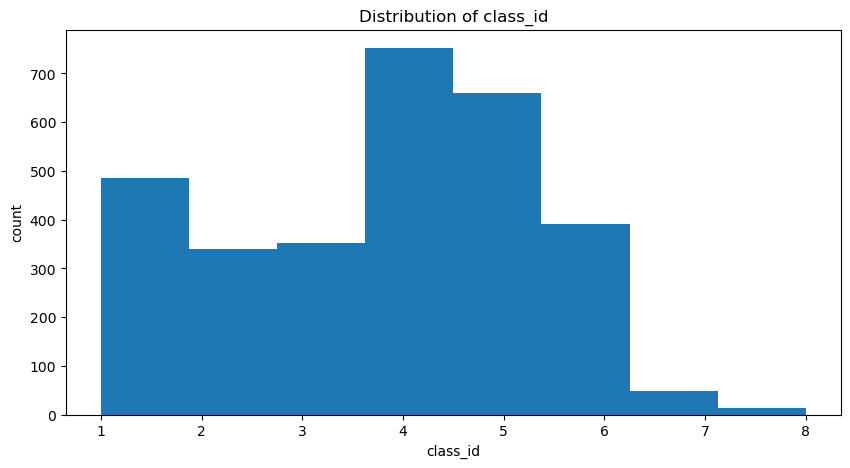

In [4]:
# Distribution of class_id
df['class_id'] = df['class_id'].astype('int8')
print(df['class_id'].value_counts())
 
# Plot the distribution of class_id
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['class_id'], bins=8)
plt.title('Distribution of class_id')
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

In [5]:
# Apply the function to the 'pixels' column
df['pixels'] = df['pixels'].apply(extract_multiple_arrays)

In [6]:
stacked_arrays = []

# Stack the arrays for each cell
for cell_pixels in df['pixels']:
    stacked_array = np.vstack(cell_pixels)
    stacked_arrays.append(stacked_array)

In [7]:
n_clusters=2
custom_kmeans = CustomKMeans(n_clusters=n_clusters)

clustered_data = []

for i in range (len(stacked_arrays)):
    custom_kmeans.fit(stacked_arrays[i])
    clustered_data.append(custom_kmeans.get_cluster_centers())

/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/si

In [8]:
clusters = np.array(clustered_data)
print("clusters shape:", clusters.shape)
labels = np.array(df['class_id'])- 1

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Split the data into training and testing sets, with stratification
train_data, test_data, train_labels, test_labels = train_test_split(
    clusters, labels, test_size=0.2, random_state=42, stratify=labels # I stratified the data to have the same distribution of classes 
)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
#print hte different possible labels
print("labels:", np.unique(labels))


clusters shape: (3039, 2, 73, 10)
train_data shape: (2431, 2, 73, 10)
train_labels shape: (2431, 8)
labels: [0 1 2 3 4 5 6 7]


In [9]:
tf.config.run_functions_eagerly(True)
class Custom_Model(tf.keras.Model):
    
    def __init__(self):
        super(Custom_Model, self).__init__()
        self.enc = Cplx_CustomCNN_1D()
        self.attn = CustomAttentionLayer(units=64)
        self.classifier = CustomClassifierModel(num_classes=8)
    
    def call(self, inputs):
        
        intermediate = tf.map_fn(self.enc, inputs, dtype=tf.float32)
        attention_outputs = tf.map_fn(lambda x: self.attn(self.enc(x)), inputs, dtype=tf.float32)

        emb = [tf.multiply(alpha, tensor) for alpha, tensor in zip(attention_outputs, intermediate)]
        emb = tf.reduce_sum(emb, axis=1)
        
        return self.classifier(emb)
    
    def summary(self):
        self.enc.summary()
        self.attn.summary()
        #self.classifier.summary()

In [10]:
from keras.optimizers.legacy import Adam as Adam_legacy


model = Custom_Model()
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
lr = 0.001

model = Custom_Model()
optimizer = Adam_legacy(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(test_data, test_labels))


2023-11-26 19:11:35.428349: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-26 19:11:35.428390: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-26 19:11:35.428394: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-26 19:11:35.429169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-26 19:11:35.429827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 71, 256)           7936      
                                                                 
 batch_normalization (Batch  (None, 71, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 71, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 69, 256)           196864    
                                                                 
 batch_normalization_1 (Bat  (None, 69, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 69, 256)           0

/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 [==============================] - 203s 5s/step - loss: 0.5536 - accuracy: 0.8071 - val_loss: 1.7500 - val_accuracy: 0.3224
Epoch 2/10
38/38 [==============================] - 207s 5s/step - loss: 0.1183 - accuracy: 0.9626 - val_loss: 1.8642 - val_accuracy: 0.2516
Epoch 3/10
38/38 [==============================] - 202s 5s/step - loss: 0.0458 - accuracy: 0.9844 - val_loss: 2.1652 - val_accuracy: 0.3273
Epoch 4/10
38/38 [==============================] - 192s 5s/step - loss: 0.0400 - accuracy: 0.9889 - val_loss: 2.7904 - val_accuracy: 0.3043
Epoch 5/10
38/38 [==============================] - 200s 5s/step - loss: 0.0531 - accuracy: 0.9844 - val_loss: 2.4774 - val_accuracy: 0.3684
Epoch 6/10
38/38 [==============================] - 204s 5s/step - loss: 0.0602 - accuracy: 0.9794 - val_loss: 2.3804 - val_accuracy: 0.3618
Epoch 7/10
38/38 [==============================] - 200s 5s/step - loss: 0.0412 - accuracy: 0.9860 - val_loss: 2.7260 - val_accuracy: 0.2878
Epoch 8/10
38/38 [======

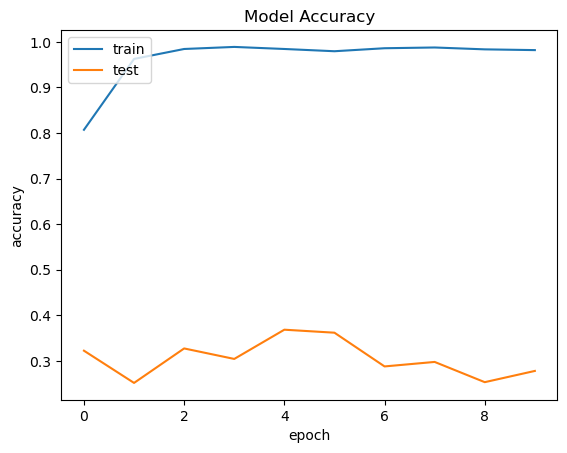

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you've trained your model and obtained predictions
predictions = model.predict(test_data)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

19/19 [==============================] - 9s 466ms/step
              precision    recall  f1-score   support

           0       0.31      0.84      0.45        97
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        70
           3       0.34      0.15      0.21       150
           4       0.40      0.49      0.44       132
           5       0.00      0.00      0.00        78
           6       0.01      0.10      0.02        10
           7       0.00      0.00      0.00         3

    accuracy                           0.28       608
   macro avg       0.13      0.20      0.14       608
weighted avg       0.22      0.28      0.22       608

Confusion Matrix:
 [[81  0  1 11  0  0  4  0]
 [59  0  0  8  0  0  1  0]
 [61  0  0  4  0  0  5  0]
 [47  0  0 22 47  0 34  0]
 [ 7  0  0 11 65  0 49  0]
 [ 1  0  0  7 49  0 21  0]
 [ 8  0  0  1  0  0  1  0]
 [ 0  0  0  0  3  0  0  0]]


/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [13]:
lr = 0.0001
model = Custom_Model()
optimizer = Adam_legacy(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(test_data, test_labels))

Epoch 1/10


/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 [==============================] - 201s 5s/step - loss: 1.0416 - accuracy: 0.6491 - val_loss: 2.4603 - val_accuracy: 0.1957
Epoch 2/10
38/38 [==============================] - 203s 5s/step - loss: 0.1687 - accuracy: 0.9741 - val_loss: 2.6213 - val_accuracy: 0.1809
Epoch 3/10
38/38 [==============================] - 204s 5s/step - loss: 0.0598 - accuracy: 0.9992 - val_loss: 2.8722 - val_accuracy: 0.2286
Epoch 4/10
38/38 [==============================] - 217s 6s/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 3.2544 - val_accuracy: 0.2385
Epoch 5/10
38/38 [==============================] - 219s 6s/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 3.7631 - val_accuracy: 0.2368
Epoch 6/10
38/38 [==============================] - 221s 6s/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 4.5067 - val_accuracy: 0.2072
Epoch 7/10
38/38 [==============================] - 236s 6s/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 5.3198 - val_accuracy: 0.2188
Epoch 8/10
38/38 [======

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you've trained your model and obtained predictions
predictions = model.predict(test_data)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

19/19 [==============================] - 9s 486ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        70
           3       0.23      0.86      0.36       150
           4       0.00      0.00      0.00       132
           5       0.14      0.04      0.06        78
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         3

    accuracy                           0.22       608
   macro avg       0.05      0.11      0.05       608
weighted avg       0.07      0.22      0.10       608

Confusion Matrix:
 [[  0   0   0  96   0   1   0   0]
 [  0   0   0  67   0   1   0   0]
 [  0   0   0  70   0   0   0   0]
 [  5   0   0 129   0  16   0   0]
 [  0   0   0 131   0   1   0   0]
 [  8   0   0  67   0   3   0   0]
 [  0   0   0  10   0   0   0   0]
 [  3   0   0   0   0   0   0 

/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

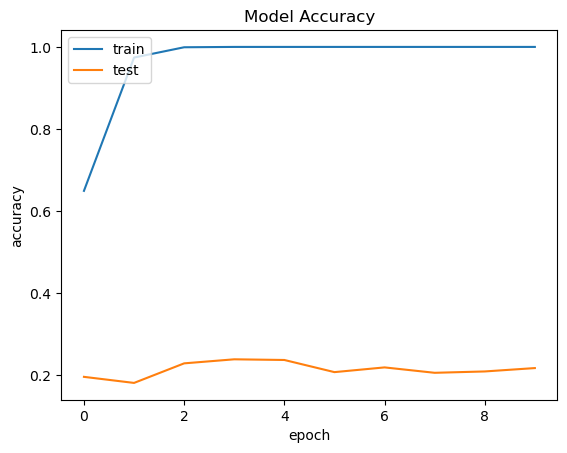

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
import tensorflow as tf

labels = np.array(df['class_id'])- 1
# list of weights for each class
weights = [1/np.sum(labels==i) for i in range(8)]
print(weights)

def weighted_categorical_crossentropy(weights):
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, weights)
        return tf.reduce_mean(loss)
    
    return loss

[0.002061855670103093, 0.0029498525073746312, 0.002849002849002849, 0.0013297872340425532, 0.0015174506828528073, 0.002564102564102564, 0.02040816326530612, 0.07142857142857142]


In [26]:
lr = 0.001
model = Custom_Model()
optimizer = Adam_legacy(learning_rate=lr)
model.compile(optimizer=optimizer, loss=weighted_categorical_crossentropy(weights), metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=6, batch_size=16, validation_data=(test_data, test_labels))

Epoch 1/6
152/152 [==============================] - 200s 1s/step - loss: 0.6294 - accuracy: 0.7014 - val_loss: 0.6682 - val_accuracy: 0.1447
Epoch 2/6
152/152 [==============================] - 205s 1s/step - loss: 0.6229 - accuracy: 0.7914 - val_loss: 0.6678 - val_accuracy: 0.1924
Epoch 3/6
152/152 [==============================] - 196s 1s/step - loss: 0.6224 - accuracy: 0.7931 - val_loss: 0.6698 - val_accuracy: 0.1661
Epoch 4/6
152/152 [==============================] - 196s 1s/step - loss: 0.6200 - accuracy: 0.8272 - val_loss: 0.6771 - val_accuracy: 0.0477
Epoch 5/6
152/152 [==============================] - 199s 1s/step - loss: 0.6171 - accuracy: 0.8643 - val_loss: 0.6647 - val_accuracy: 0.2385
Epoch 6/6
152/152 [==============================] - 203s 1s/step - loss: 0.6159 - accuracy: 0.8811 - val_loss: 0.6719 - val_accuracy: 0.1234


[0.002061855670103093, 0.0029498525073746312, 0.002849002849002849, 0.0013297872340425532, 0.0015174506828528073, 0.002564102564102564, 0.02040816326530612, 0.07142857142857142]
